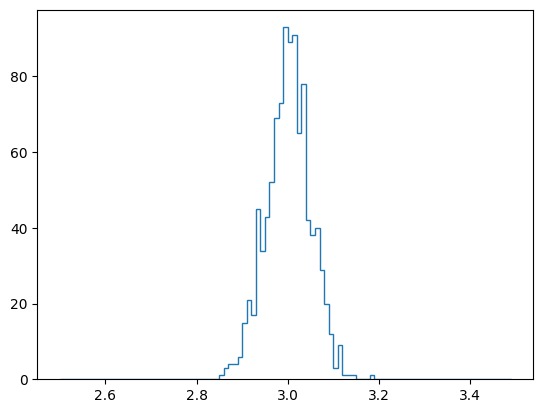

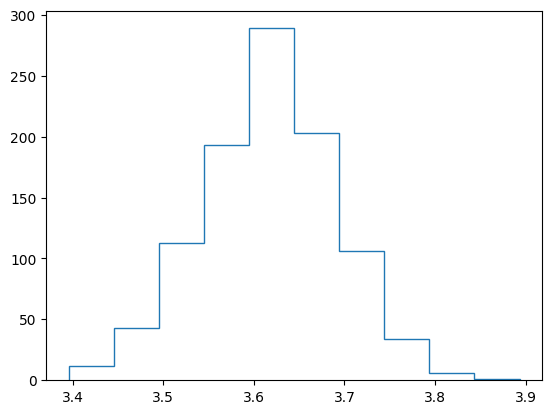

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

# test for new prior function - redshift prior is basically set by observed line width 

#spec_wobs = norm(loc=3.,scale=0.05)

#xrange = np.linspace(2.,4.,100)

#pobs = spec_wobs.pdf(xrange)

#plt.plot(xrange,pobs)
#plt.show()

# halpha rest wavelength is 0.65

##rest = 0.65 

#pz = (pobs/rest)-1.

#plt.plot(xrange,pz)
#plt.show()

rest = 0.65 
pl = np.random.normal(loc=3.,scale=0.05,size=1000)

plt.hist(pl,histtype='step',bins=np.arange(2.5,3.5,0.01))
plt.show()

pz = (pl/rest)-1.

plt.hist(pz,histtype='step')
plt.show()


In [19]:
nsamp = 64
xline = np.linspace(-nsamp, nsamp, 2*nsamp+1)/nsamp*0.1+1
yline = xline*0.
yline[nsamp] = 1
yline /= np.trapz(yline, xline)

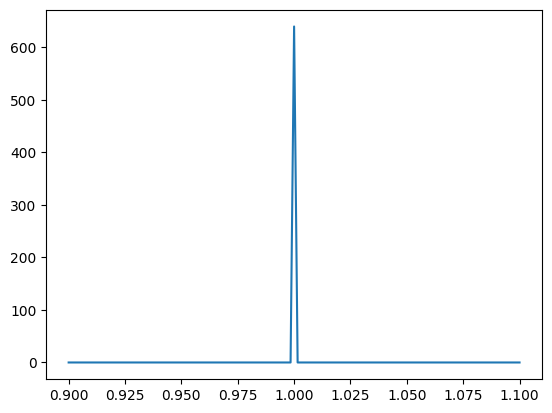

In [20]:
plt.plot(xline,yline)

In [11]:
print(nsamp*0.1+1)

7.4


In [12]:
print(xline)

[0.9       0.9015625 0.903125  0.9046875 0.90625   0.9078125 0.909375
 0.9109375 0.9125    0.9140625 0.915625  0.9171875 0.91875   0.9203125
 0.921875  0.9234375 0.925     0.9265625 0.928125  0.9296875 0.93125
 0.9328125 0.934375  0.9359375 0.9375    0.9390625 0.940625  0.9421875
 0.94375   0.9453125 0.946875  0.9484375 0.95      0.9515625 0.953125
 0.9546875 0.95625   0.9578125 0.959375  0.9609375 0.9625    0.9640625
 0.965625  0.9671875 0.96875   0.9703125 0.971875  0.9734375 0.975
 0.9765625 0.978125  0.9796875 0.98125   0.9828125 0.984375  0.9859375
 0.9875    0.9890625 0.990625  0.9921875 0.99375   0.9953125 0.996875
 0.9984375 1.        1.0015625 1.003125  1.0046875 1.00625   1.0078125
 1.009375  1.0109375 1.0125    1.0140625 1.015625  1.0171875 1.01875
 1.0203125 1.021875  1.0234375 1.025     1.0265625 1.028125  1.0296875
 1.03125   1.0328125 1.034375  1.0359375 1.0375    1.0390625 1.040625
 1.0421875 1.04375   1.0453125 1.046875  1.0484375 1.05      1.0515625
 1.053125  1.05468

In [18]:
print(np.trapz(yline, xline))

0.0015624999999999667


In [21]:
import os
from grizli import utils

In [22]:
def resample_template_numba(spec_wobs, spec_R_fwhm, templ_wobs, templ_flux, velocity_sigma=100, nsig=5, fill_value=0.):
    """
    Resample a high resolution template/model on the wavelength grid of a
    spectrum with (potentially) wavelength dependent dispersion
    
    Parameters
    ----------
    spec_wobs : array-like
        Spectrum wavelengths
    
    spec_R_fwhm : array-like
        Spectral resolution `wave/d(wave)`, FWHM
    
    templ_wobs : array-like
        Template wavelengths, observed frame.  Same units as `spec_wobs`.  
        **NB:** both `spec_wobs` and `templ_wobs` assumed to be sorted!
    
    templ_flux : array-like
        Template flux densities sampled at `templ_wobs`
    
    velocity_sigma : float
        Kinematic velocity width, km/s
    
    nsig : float
        Number of sigmas of the Gaussian convolution kernel to sample
    
    Returns
    -------
    resamp : array-like
        Template resampled at the `spec_wobs` wavelengths, convolved with a 
        Gaussian kernel with sigma width
        
        >>> Rw = 1./np.sqrt((velocity_sigma/3.e5)**2 + 1./(spec_R_fwhm*2.35)**2)
        >>> dw = spec_wobs / Rw
    
    """    
    dw = np.sqrt((velocity_sigma/3.e5)**2 + (1./2.35/spec_R_fwhm)**2)*spec_wobs
    
    #Rw = 1./np.sqrt((velocity_sigma/3.e5)**2 + 1./(spec_R_fwhm*2.35)**2)
    # dw = spec_wobs / Rw
    
    ilo = 0
    ihi = 1
    
    N = len(spec_wobs)
    resamp = np.zeros_like(spec_wobs)*fill_value
    
    Nt = len(templ_wobs)
    
    for i in range(N):
        #sl = slice(ilo[i], ihi[i])
        while (templ_wobs[ilo] < spec_wobs[i]-nsig*dw[i]) & (ilo < Nt-1):
            ilo += 1
        
        if ilo == 0:
            continue
            
        ilo -= 1
        
        while (templ_wobs[ihi] < spec_wobs[i]+nsig*dw[i]) & (ihi < Nt):
            ihi += 1
        
        if (ilo >= ihi):
            resamp[i] = templ_flux[ihi]
            continue
        elif (ilo == Nt-1):
            break
            
        sl = slice(ilo, ihi)
        lsl = templ_wobs[sl]
        g = np.exp(-(lsl-spec_wobs[i])**2/2/dw[i]**2)/np.sqrt(2*np.pi*dw[i]**2)
        # g *= 1./np.sqrt(2*np.pi*dw[i]**2) 
        resamp[i] = np.trapz(templ_flux[sl]*g, lsl)
        
    return resamp

In [ ]:
res = self.resample_func(spec_wobs,
                                 spec_R_fwhm*scale_disp, 
                                 self.xline*line_um,
                                 self.yline,
                                 velocity_sigma=velocity_sigma,
                                 nsig=nsig)